## Importing libraries

In [1]:
import numpy as np
import csv
import sys
import os
import pandas as pd

from matplotlib import pyplot as plt , rcParams, rc
%matplotlib inline

import matplotlib.image as mpimg

from scipy.misc import bytescale
from scipy.misc import imresize
from scipy.ndimage import imread

from PIL import Image

import shutil

from shutil import copyfile

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


### Reading data

For plants grown outside the lab

In [2]:
%ls ~/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-11-06/pdu

bkg-r1.rawc*     can3S1-r1.rawc*  rad1S1-r1.rawc*  rad4S1-r1.rawc*
can1S1-r1.rawc*  can4S1-r1.rawc*  rad2S1-r1.rawc*  rad5S1-r1.rawc*
can2S1-r1.rawc*  can5S1-r1.rawc*  rad3S1-r1.rawc*


##### Data directory path

In [3]:
Dir= "/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/"

Stage1= "Data-2017-11-06/"
Stage2= "Data-2017-11-13/"
Stage3= "Data-2017-11-20/"
Stage4= "Data-2017-11-27/"
Stage5= "Data-2017-12-04/"

S1Dir=Dir+Stage1+"pdu/"
S2Dir=Dir+Stage2+"pdu/"
S3Dir=Dir+Stage3+"pdu/"
S4Dir=Dir+Stage4+"pdu/"
S5Dir=Dir+Stage5+"pdu/"
S5Dir


'/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-12-04/pdu/'

In [4]:
os.listdir(S1Dir)

['rad5S1-r1.rawc',
 'rad3S1-r1.rawc',
 'rad1S1-r1.rawc',
 'can2S1-r1.rawc',
 'rad2S1-r1.rawc',
 'can4S1-r1.rawc',
 'rad4S1-r1.rawc',
 'can5S1-r1.rawc',
 'bkg-r1.rawc',
 'can1S1-r1.rawc',
 'can3S1-r1.rawc']

### listing the files in data path

In [5]:
def list_files(Path, name_prefix='',file_ext='', exclude_ext=' -r1.rawc'):
    import os
    files = []; # Default return empty list if directory does not exist
    
    if os.path.isdir(Path):
        files = [f for f in os.listdir(Path) if (f.endswith(file_ext) and \
                                                     f.startswith(name_prefix) and \
                                                     (not f.endswith(exclude_ext)) and \
                                                     os.path.isfile(Path+'/'+f) )]
    return files

In [6]:
S1_names= list_files(S3Dir, "can")
S1_names[:]

['can2S3-r1.rawc',
 'can3S3-r1.rawc',
 'can5S3-r1.rawc',
 'can1S3-r1.rawc',
 'can4S3-r1.rawc']

#### Reading All files in path of certain day data collection 

#### Reading files belong to one a certain stage

### Getting plants files

In [7]:
CanS1_files= list_files(S1Dir, "can")
CanS2_files= list_files(S2Dir, "can")
CanS3_files= list_files(S3Dir, "can")
CanS4_files= list_files(S4Dir, "can")
CanS5_files= list_files(S5Dir, "can")

RadS1_files= list_files(S1Dir, "rad")
RadS2_files= list_files(S2Dir, "rad")
RadS3_files= list_files(S3Dir, "rad")
RadS4_files= list_files(S4Dir, "rad")
RadS5_files= list_files(S5Dir, "rad")

print CanS1_files[:]

['can2S1-r1.rawc', 'can4S1-r1.rawc', 'can5S1-r1.rawc', 'can1S1-r1.rawc', 'can3S1-r1.rawc']


##### Data path (For only one of the five data collection)

### Up to here

Reading file

#### Defining reading files function

In [8]:
def ReadingFiles(Path, Files):
    %cd {Path}
    
    Data=[]
    for i in range(len(Files)):
        Files1= np.loadtxt(Files[i],delimiter=',',dtype=None)
        Data.append(Files1)
    return Data;

In [9]:
CanS1= ReadingFiles(S1Dir, CanS1_files);
RadS1= ReadingFiles(S1Dir, RadS1_files);

CanS2= ReadingFiles(S2Dir, CanS2_files);
RadS2= ReadingFiles(S2Dir, RadS2_files);

CanS3= ReadingFiles(S3Dir, CanS3_files);
RadS3= ReadingFiles(S3Dir, RadS3_files);

CanS4= ReadingFiles(S4Dir, CanS4_files);
RadS4= ReadingFiles(S4Dir, RadS4_files);

CanS5= ReadingFiles(S5Dir, CanS5_files);
RadS5= ReadingFiles(S5Dir, RadS5_files);

/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-11-06/pdu
/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-11-06/pdu
/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-11-13/pdu
/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-11-13/pdu
/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-11-20/pdu
/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-11-20/pdu
/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-11-27/pdu
/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-11-27/pdu
/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-12-04/pdu
/home/ubuntu/courses/fastai/ESRI/PDU_Raw_Data01/Data-2017-12-04/pdu


In [10]:
CanS3[2].shape, RadS2[2].shape

((6840, 409), (6837, 409))

#### Reading beam position, lasers reflections and background and stack them together

In [11]:
def ArrayofLasers(Array): 
    beam_position=Array[:,0]
    L635 = Array[:,1::4]
    L685 = Array[:, 2::4]
    L785 = Array[:, 3::4]
    BKG = Array[:, 4::4]
    
    # Making beam positions equal to Laser size to stack    
    beam_position_matrix = np.empty((L635.shape[0],L635.shape[1]))
    for i in range(L635.shape[1]):
        beam_position_matrix[:,i] = beam_position
        
    TotArr = np.stack([beam_position_matrix, L635, L685, L785, BKG])
    return TotArr 

##### Testing ArrayofLasers function:

In [12]:
Can1S1= ArrayofLasers(CanS1[0]);
Can2S1= ArrayofLasers(CanS1[1]);
#..
Can1S1.shape, Can2S1.shape, Can1S1[4][5000][80]

((5, 6951, 102), (5, 6954, 102), 15.0)

Just testing: Writting preliminary code fro testing, before writting the AllFiveFiles function 

##### Checking the mininimum scan lines finder

### Making an array of all 5 files in each stage

The first argument shows file number, (not yet)

The second one is 0=beam_position_matrix, 1=L635, 2=L685, 3=L785, 4=BKG

The third one is number of lines in scans

The last one is beam reflection number=102


In [13]:
def AllFiveFiles(TotArr):
    A=[]

    for i in range(len(TotArr)):
        B=TotArr[i].shape[0]
        A.append(B)
    Line_min=np.min(A)
    
    
    
    Bigarray = np.empty((len(TotArr),5,Line_min,102))
    for i in range(5):
        Bigarray[i,...] = ArrayofLasers(TotArr[i])[:,:Line_min,:]
    return Bigarray    

Testing all files function

In [14]:
AllFiveFiles(CanS1)[1][3][5000:5050][19:48]

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
CanS1Data=AllFiveFiles(CanS1)
RadS1Data=AllFiveFiles(RadS1)

CanS2Data=AllFiveFiles(CanS2)
RadS2Data=AllFiveFiles(RadS2)

CanS3Data=AllFiveFiles(CanS3)
RadS3Data=AllFiveFiles(RadS3)

CanS4Data=AllFiveFiles(CanS4)
RadS4Data=AllFiveFiles(RadS4)

CanS5Data=AllFiveFiles(CanS5)
RadS5Data=AllFiveFiles(RadS5)

In [16]:
CanS1Data[0, 1, 200, 57:87], CanS1Data.shape

(array([109.,  11.,  79.,  12.,  63.,  15.,  48.,  32.,   7.,  18.,   5.,
         12.,   0.,  21.,   0.,  23.,   1.,  68.,   3.,  70.,   2.,  93.,
          3.,  50.,   2., 100.,   2.,  67.,   1.,  49.]), (5, 5, 6951, 102))

### Making NN Folders

In [17]:
path = Dir+ 'Test06_NDVI_150*150/'
if not os.path.exists(path): os.mkdir(path) 
os.chdir(path)
#path

train_path= path + 'train/'
if not os.path.exists(train_path): os.mkdir(train_path) 
#train_path

valid_path= path + 'valid/'
if not os.path.exists(valid_path): os.mkdir(valid_path) 
#valid_path

test_path= path + 'test/'
if not os.path.exists(test_path): os.mkdir(test_path) 
#test_path

sample_path= path + 'sample/'
if not os.path.exists(sample_path): os.mkdir(sample_path) 
#sample_path

model_path= path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path) 
#model_path

To see all the array

In [25]:
ii=2
WinL635= CanS4Data[ii,1,200:400, range(18,48)]
WinL685= CanS4Data[ii,2,200:400, range(18,48)]
WinL785= CanS4Data[ii,3,200:400, range(18,48)]
WinBKG = CanS4Data[ii,4,200:400, range(18,48)]

NDVI_1= ((WinL635-WinL685)/(WinL635+WinL685))
NDVI_2= ((WinL635-WinL785)/(WinL635+WinL785))
NDVI_3= ((WinL685-WinL785)/(WinL685+WinL785))

NDVI_1= (NDVI_1+1)*128
NDVI_2= (NDVI_2+1)*128
NDVI_3= (NDVI_3+1)*128

NDVI_1= bytescale(NDVI_1, cmin=0, cmax=255)
NDVI_2= bytescale(NDVI_2, cmin=0, cmax=255)
NDVI_3= bytescale(NDVI_3, cmin=0, cmax=255)

NDVI_1= imresize(NDVI_1,(150,150), interp="bicubic")
NDVI_2= imresize(NDVI_2,(150,150), interp="bicubic")
NDVI_3= imresize(NDVI_3,(150,150), interp="bicubic")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be remo

#### Defining a function to get window sizes and give data matrixes (frames)

Left lasers =18:48  Right lasers=57:87

In [28]:
# We need to write some part to clean all the folders 

def GettingFiles(Dataset,  Stage, Type, num_of_wins=200,  Skip=1, num_lines=750):
    '''Dataset: Variables Dataset 
    Stage= Enter your Stage as an string Ex: Stage1
    Type= Enter your Type of your plant Ex: Canola
    num_of_wins=Number of windows we wish to have
    If we want to skip a line: Skip
    Number of scans: Num_lines default=750
    '''
    targ=150
    Num_of_wins=num_of_wins  # Number of windows we want in each side
    Num_lines=num_lines
    skip=Skip    

    Left_side_Width= range(18,48)
    Right_side_Width= range(57,87)
    Side= [Left_side_Width, Right_side_Width] # 0=Left  1=Right

    DataFrame_L635=[]
    DataFrame_L685=[]
    DataFrame_L785=[]
    DataFrame_BKG=[]

    # Selecting randomly the window frames among all the line scans 
    np.random.seed(1000)
    Total_length_Size= Dataset.shape[2]
    End=Total_length_Size-Num_lines-200  # 200 is reduced from end due to soil area
    Start=sorted(np.random.randint(100, End, Num_of_wins)) # Start at 100 line due to the soil
 
    Im3D= np.zeros((targ,targ,3), 'uint8')
    Im4D= np.zeros((targ,targ,4), 'uint8')

    # The three first dataset is devoted to the training and the forth for 
    # the validation and the last set as the testing 
    i=0 
    for ii in range(5):
        if ii==4:
            os.chdir(test_path)
            i=0
        elif ii==3:
            os.chdir(valid_path)
            i=0
        else:
            os.chdir(train_path)
        # We need to give to the function the Stage ex: Stage="Stage1"
        S='/'+Stage+'/'
        stage_path= os.getcwd() + S
        if not os.path.exists(stage_path): os.mkdir(stage_path) 
        os.chdir(stage_path)

        PlantType_Path= stage_path+Type
        if not os.path.exists(PlantType_Path): os.mkdir(PlantType_Path)
        os.chdir(PlantType_Path)


        for side in Side:
            for start in Start:
                WinL635= Dataset[ii,1,start:start+Num_lines:skip, side]
                WinL685= Dataset[ii,2,start:start+Num_lines:skip, side]
                WinL785= Dataset[ii,3,start:start+Num_lines:skip, side]
                WinBKG= Dataset[ii,4,start:start+Num_lines:skip, side]
                
                # Making NDVI values
                NDVI_1= ((WinL635-WinL685)/(WinL635+WinL685))
                NDVI_2= ((WinL635-WinL785)/(WinL635+WinL785))
                NDVI_3= ((WinL685-WinL785)/(WinL685+WinL785))
                
                # To change the range into 0-255
                NDVI_1= (NDVI_1+1)*128
                NDVI_2= (NDVI_2+1)*128
                NDVI_3= (NDVI_3+1)*128
                
                #Byte scaling means converting the input image to uint8 dtype 
                # and scaling the range to ``(low, high)
                NDVI_1= bytescale(NDVI_1, cmin=0, cmax=255)
                NDVI_2= bytescale(NDVI_2, cmin=0, cmax=255)
                NDVI_3= bytescale(NDVI_3, cmin=0, cmax=255)
                
                # Resizing the NDVIs to 150*150
                NDVI_1= imresize(NDVI_1,(targ,targ), interp="bicubic")
                NDVI_2= imresize(NDVI_2,(targ,targ), interp="bicubic")
                NDVI_3= imresize(NDVI_3,(targ,targ), interp="bicubic")
                WinBKG= imresize(WinBKG,(targ,targ), interp="bicubic")
                
                # Making 3D and 4D images from NDVI arrays and BKG
                Im3D[..., 0]= NDVI_1
                Im4D[..., 0]= NDVI_1

                Im3D[..., 1]= NDVI_2
                Im4D[..., 1]= NDVI_2

                Im3D[..., 2]= NDVI_3
                Im4D[..., 2]= NDVI_3

                Im4D[..., 3]= WinBKG

                img3d = Image.fromarray(Im3D)
                
                img4d = Image.fromarray(Im4D)

                i=i+1
                img3d.save(Stage+"_"+str(i)+".jpeg")

    #for StrWidth in Right_side_Win:
    #DataFrame_L635   

### Getting files and saving them

In [29]:
GettingFiles(CanS1Data, Stage="Stage1", Type= "Canola")
GettingFiles(CanS2Data, Stage="Stage2", Type= "Canola")
GettingFiles(CanS3Data, Stage="Stage3", Type= "Canola")
GettingFiles(CanS4Data, Stage="Stage4", Type= "Canola")
GettingFiles(CanS5Data, Stage="Stage5", Type= "Canola")

GettingFiles(RadS1Data, Stage="Stage1", Type= "Radish")
GettingFiles(RadS2Data, Stage="Stage2", Type= "Radish")
GettingFiles(RadS3Data, Stage="Stage3", Type= "Radish")
GettingFiles(RadS4Data, Stage="Stage4", Type= "Radish")
GettingFiles(RadS5Data, Stage="Stage5", Type= "Radish")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:81: DeprecationWarning: `imresize` i

### Making total folder for each dataset and copy the stages in to the total folder 

In [30]:
path= [train_path, test_path, valid_path]
St= ["Stage1","Stage2","Stage3","Stage4","Stage5"]

for Path in path:
    os.chdir(Path)
    Tot_Path= Path+"/Total"
    if not os.path.exists(Tot_Path): os.mkdir(Tot_Path)        
    
    
    Can_DIR= Tot_Path+"/Canola"
    if not os.path.exists(Can_DIR): os.mkdir(Can_DIR)
        
    Rad_DIR= Tot_Path+"/Radish"
    if not os.path.exists(Rad_DIR): os.mkdir(Rad_DIR) 
        
    for Stage in St: 
        SrcC= Path+Stage+"/Canola"
        SrcR= Path+Stage+"/Radish"

        SrcC_files = os.listdir(SrcC)                
        for file_name in SrcC_files:
            full_file_name = os.path.join(SrcC, file_name)
            if (os.path.isfile(full_file_name)):
                shutil.copy(full_file_name, Can_DIR)

        SrcR_files = os.listdir(SrcR)                
        for file_name in SrcR_files:
            full_file_name = os.path.join(SrcR, file_name)
            if (os.path.isfile(full_file_name)):
                shutil.copy(full_file_name, Rad_DIR)        


### Plotting one of the result

###### Defining the plot function

In [31]:
os.chdir(Rad_DIR)
Rad_images= os.listdir(Rad_DIR)
Rad_images[3]

'Stage3_8.jpeg'

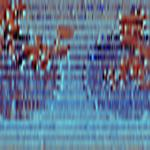

In [32]:
from IPython.display import display, Image
display(Image(Rad_images[3]))

(150, 150, 3)

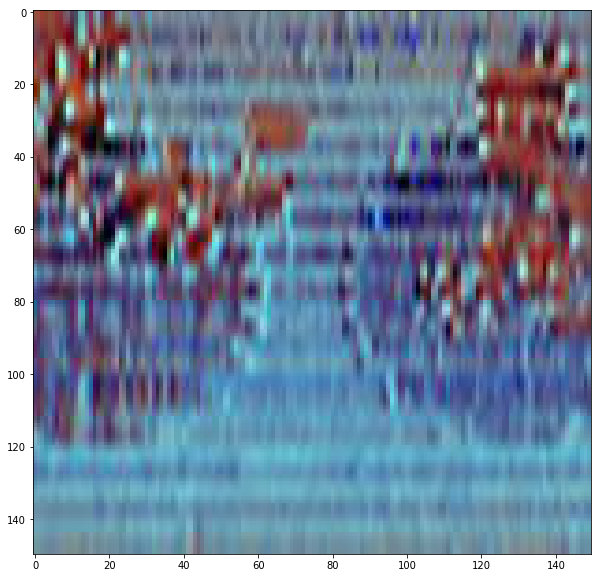

In [33]:
plt.figure(figsize=(10, 10), frameon=False)
plt.imshow(mpimg.imread(Rad_images[3]), aspect='auto', cmap='viridis')
mpimg.imread(Rad_images[3]).shape

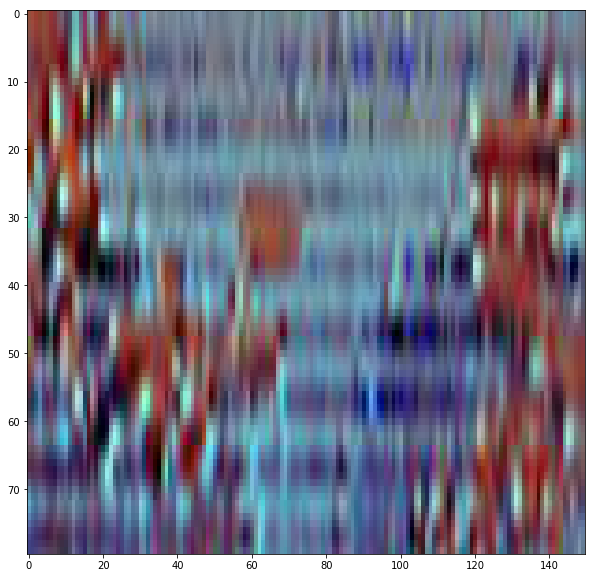

In [34]:
plt.figure(figsize=(10, 10), frameon=False)

plt.imshow(mpimg.imread(Rad_images[3])[0:80,:], aspect='auto', cmap='viridis')